## Use BPSK

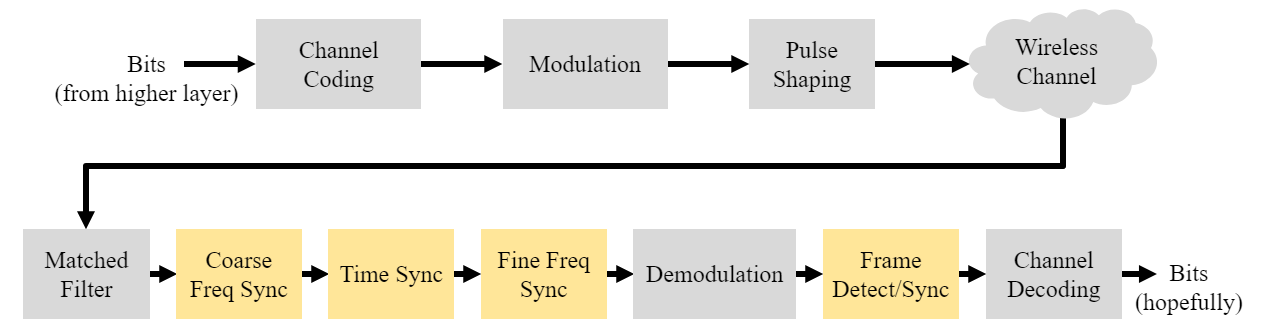

In [1]:
from IPython.display import Image
Image("diagram.png")

# Generate bits
## Use Barker code as a preamble

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

# this part came from pulse shaping exercise
num_symbols = 1000 # 89
sps = 8 # Количество добавленных нулей
bits = np.array([])
bits = np.append(bits, [1,1,1,0,0,0,1,0,0,1,0]) # add preamble
bits = np.append(bits, np.random.randint(0, 2, num_symbols))
#bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

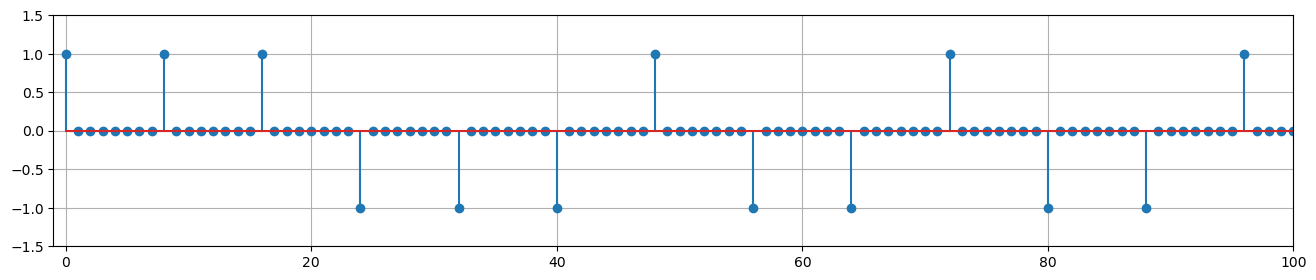

In [3]:
# %matplotlib Qt5 - use Qt5 framework and create interactive window
fig, ax = plt.subplots(figsize=(16, 3))
ax.stem(pulse_train)
ax.set_xlim([-1, 100])
ax.set_ylim([-1.5, 1.5])
ax.grid(True)

# Create and apply raised-cosine filter

In [4]:
# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)
samples_before = samples

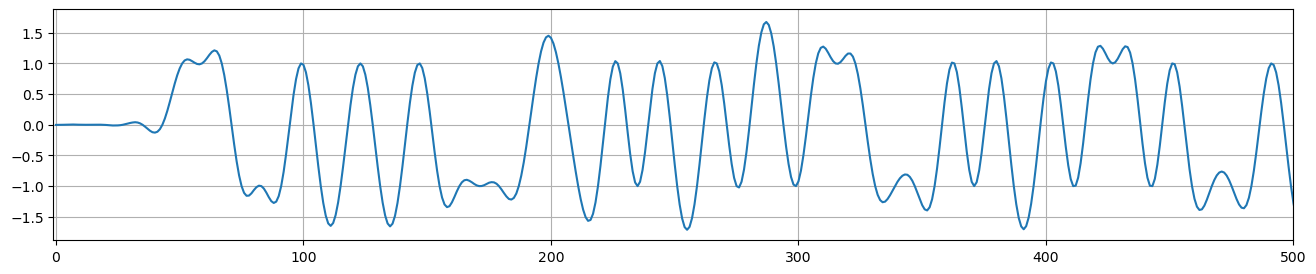

In [5]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(samples)
ax.set_xlim([-1, 500])
ax.grid(True)

In [6]:
# Create and apply fractional delay filter
delay = 0.4 # fractional delay, in samples
N = 21 # number of taps
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
samples = np.convolve(samples, h) # apply filter
samples_after = samples

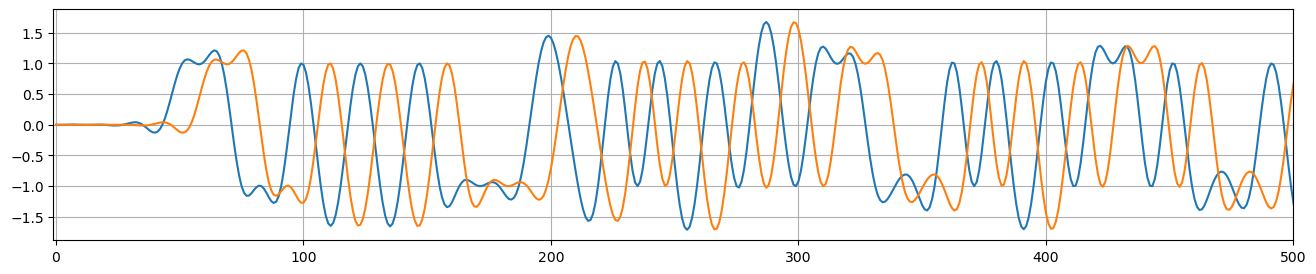

In [7]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(samples_before.real)
ax.plot(samples_after.real)
ax.set_xlim([-1, 500])
ax.grid(True)

In [8]:
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 13000 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(1j*2*np.pi*fo*t) # perform freq shift
samples_for_iq = samples

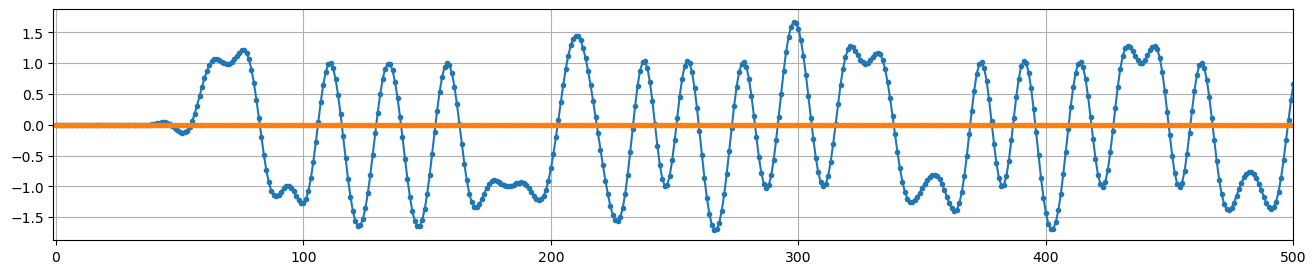

In [9]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(samples_after.real, '.-')
ax.plot(samples_after.imag, '.-')
# ax.plot(samples.real, '.-')
# ax.plot(samples.imag, '.-')
ax.set_xlim([-1, 500])
ax.grid(True)

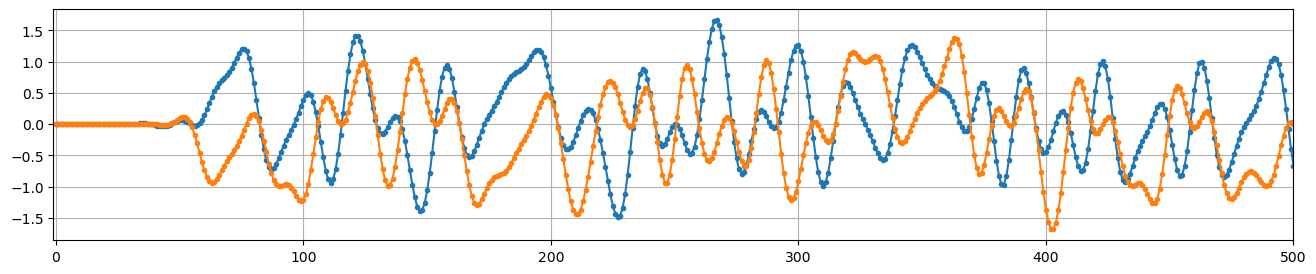

In [10]:
fig, ax = plt.subplots(figsize=(16, 3))
# ax.plot(samples_after.real, '.-')
# ax.plot(samples_after.imag, '.-')
ax.plot(samples.real, '.-')
ax.plot(samples.imag, '.-')
ax.set_xlim([-1, 500])
ax.grid(True)

## use the following equation for our coarse frequency sync

## $r^2(t) = s^2(t) e^{j4{\pi}f_{o}t}$

carrier offset = 26008.039956145687


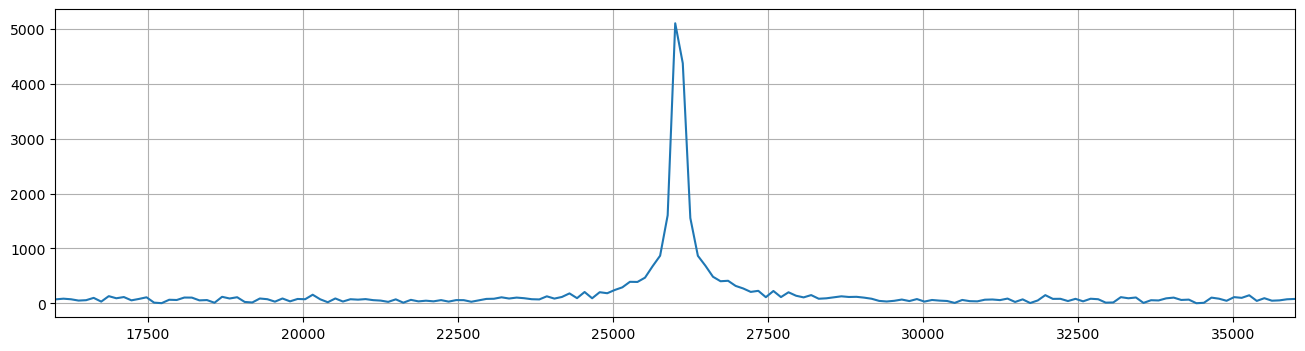

In [11]:
# Add this before the FFT line
samples_pow = samples**2
psd = np.fft.fftshift(np.abs(np.fft.fft(samples_pow)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
max_freq = f[np.argmax(psd)]
print("carrier offset =", max_freq)
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(-1j*2*np.pi*max_freq*t/2.0)

# Print frequency offset
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(f, psd)
ax.set_xlim([max_freq-10000, max_freq+10000])
ax.grid(True)

In [12]:
samples_interpolated = signal.resample_poly(samples, 16, 1) # samples_interpolated

In [13]:
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=complex)
out_rail = np.zeros(len(samples) + 10, dtype=complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples_interpolated[i_in*16 + int(mu*16)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on

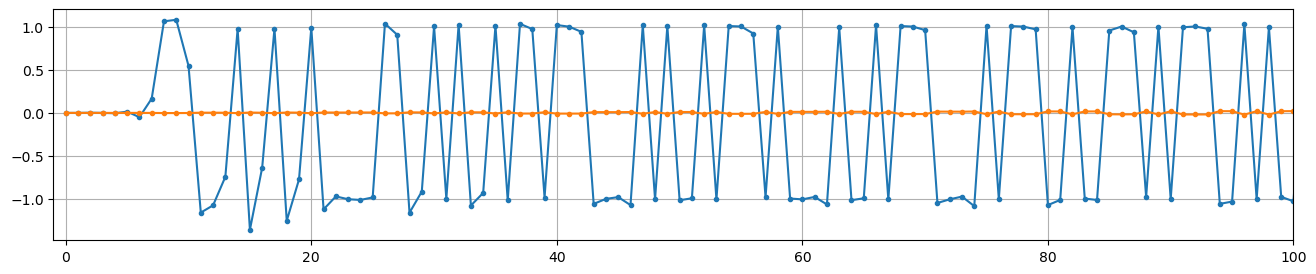

In [14]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(samples.real, '.-')
ax.plot(samples.imag, '.-')
ax.set_xlim([-1, 100])
ax.grid(True)

## before time sync

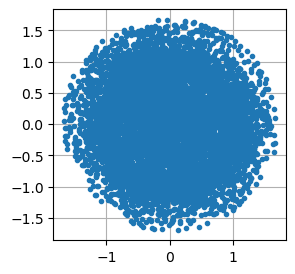

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(samples_for_iq[30:].real, samples_for_iq[30:].imag, '.')
ax.grid(True)

## after time sync

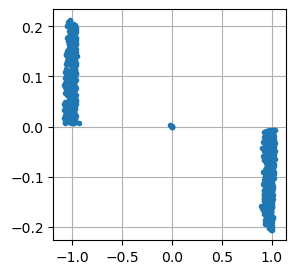

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(samples[30:].real, samples[30:].imag, '.')
ax.grid(True)

# Use Costas Loop for fine frequency synchronization

In [17]:
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 0.132
beta = 0.00932
out = np.zeros(N, dtype=complex)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi*sps)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

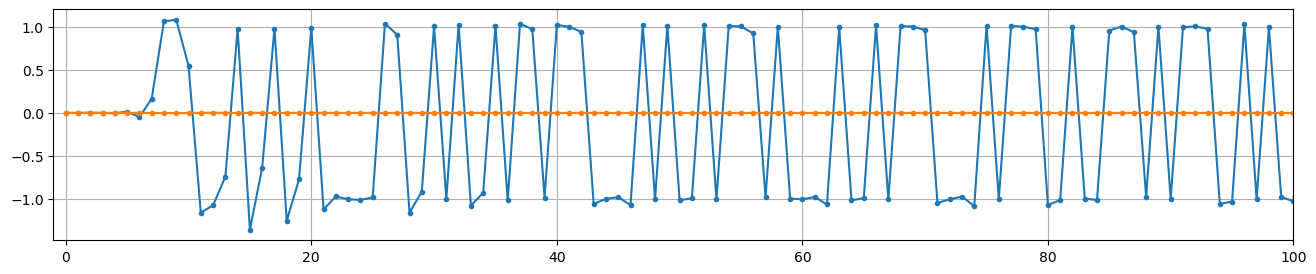

In [18]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(out.real, '.-')
ax.plot(out.imag, '.-')
ax.set_xlim([-1, 100])
ax.grid(True)

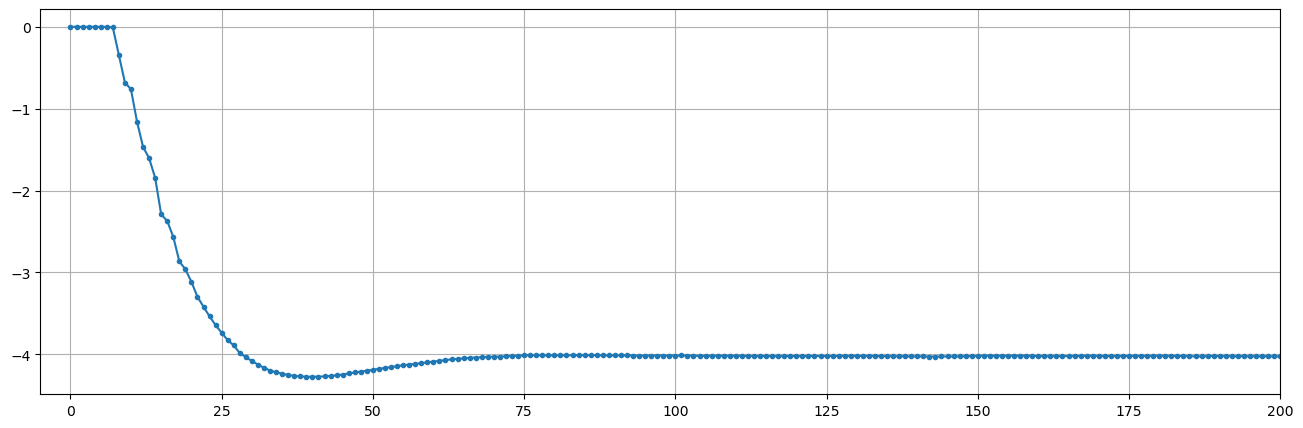

In [19]:
# Plot freq over time to see how long it takes to hit the right offset
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(freq_log, '.-')
ax.set_xlim([-5, 200])
ax.grid(True)